In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os
from tqdm import tqdm

# first I need to load in all frames
# focusing on one action type at a time, I want to plot the ground truth tubes
# and also plot the predicted tubes
# plot box onto frame with color and label
def plot_box_label(frame, box, label, color=(0, 255, 0)):
    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(frame, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 1)
    return frame

action_class_selection_map = [0, 1, 2, 3, 4, 5, -1, 6, 7, 8, 9, 10, 11, 12, -1, -1, 13, 14, 15, 16, 17, 18]


In [3]:
with open("/road/road_trainval_v1.0.json", "r") as f:
    fs = f.read()
    ann_dict = json.loads(fs)

det_tubes = pickle.load(open('./train_3/processed/tubes/tubes.pkl', 'rb'))
frame_level_dets = pickle.load(open('./train_3/processed/frame-level-dets.pkl', 'rb'))

In [24]:
len([{each: val} for each, val in ann_dict['db']["2015-02-13-09-16-26_stereo_centre_02"]['action_tubes'].items() if val['label_id']==action_class_selection_map.index(14)])

8

In [6]:
videoname = "2014-11-18-13-20-12_stereo_centre_05" # "2015-02-13-09-16-26_stereo_centre_02"
framewise_det_tubes = {}
for i, tube in enumerate(det_tubes['action'][videoname]):
    if tube['label_id'] == 14:
        for j, frame_id in enumerate(tube['orig_frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            if frame_id == 309:
                print(tube['boxes'][j], j)
            box = {'box': tube['boxes'][j], 'tube_uid': i, 'conf_order': tube['confidence_order'], 'conf': tube['scores'][j]}
            framewise_det_tubes[str(frame_id)].append(box)


#print(det_tubes['action'][videoname][173]['boxes'][58])
#framewise_det_tubes['309']

In [8]:
# run this cell to produce video!!
videoname =  "2014-11-18-13-20-12_stereo_centre_05"# "2015-02-13-09-16-26_stereo_centre_02" #"2014-06-26-09-53-12_stereo_centre_02"
real_action = 0
action = action_class_selection_map.index(real_action) # Red
frame_paths = sorted(os.listdir(f'/road/rgb-images/{videoname}'))

framewise_det_tubes = {}
for i, tube in enumerate(det_tubes['action'][videoname]):
    if tube['label_id'] == real_action:
        for j, frame_id in enumerate(tube['orig_frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i, 'conf_order': tube['confidence_order'], 'conf': tube['scores'][j]}
            framewise_det_tubes[str(frame_id)].append(box)

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

print(testframe.shape)
out = cv2.VideoWriter(f"tubeacar_{videoname}_{ann_dict['all_action_labels'][action]}_dets.mp4",cv2.VideoWriter_fourcc(*'mp4v'), 12, (testframe.shape[1], testframe.shape[0]))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    if frame_id == 309:
        print('lol')
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    if 'annos' in ann_dict['db'][videoname]['frames'][str(frame_id)]:
        for key, anno in ann_dict['db'][videoname]['frames'][str(frame_id)]['annos'].items():
            if action in anno['action_ids']:
                xmin = int(round(anno['box'][0]*1280))
                ymin = int(round(anno['box'][1]*920))
                xmax = int(round(anno['box'][2]*1280))
                ymax = int(round(anno['box'][3]*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), anno['tube_uid'], (0, 255, 0))
    if str(frame_id) in framewise_det_tubes:
        for anno in framewise_det_tubes[str(frame_id)]:
            xmin = int(round(anno['box'][0]/682*1280))
            ymin = int(round(anno['box'][1]/512*920))
            xmax = int(round(anno['box'][2]/682*1280))
            ymax = int(round(anno['box'][3]/512*920))
            frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), f"{str(anno['tube_uid'])} {str(anno['conf_order'])} {'%.3f' % anno['conf']}", (0, 0, 255))
    cv2.putText(frame, str(frame_id), (frame.shape[1]-100, frame.shape[0]-25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    out.write(frame)

out.release()

print('done writing video')

(960, 1280, 3)


  5%|▌         | 315/6000 [00:07<02:12, 43.06it/s]

lol


100%|██████████| 6000/6000 [02:14<00:00, 44.60it/s]

done writing video


In [9]:

with open("/road/road_trainval_v1.0.json", "r") as f:
    fs = f.read()
    ann_dict = json.loads(fs)

det_tubes = pickle.load(open('./train_3/processed/tubes/tubes.pkl', 'rb'))
frame_level_dets = pickle.load(open('./train_3/processed/frame-level-dets.pkl', 'rb'))
videoname =  "2014-11-18-13-20-12_stereo_centre_05"#"2015-02-13-09-16-26_stereo_centre_02"
action = 14 #Wait2X # Red
frame_paths = sorted(os.listdir(f'/road/rgb-images/{videoname}'))

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

out = cv2.VideoWriter(f'frame_level_{videoname}_action.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 12, (testframe.shape[1], testframe.shape[0]))
cnt =0
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    frame_level_key = f"{videoname}%05d" % frame_id
    if frame_level_key in frame_level_dets['action']:
        for class_idx, class_boxes in enumerate(frame_level_dets['action'][frame_level_key]):
            for box in class_boxes:
                xmin = int(round(box[0]/682*1280))
                ymin = int(round(box[1]/512*920))
                xmax = int(round(box[2]/682*1280))
                ymax = int(round(box[3]/512*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax),f"{ann_dict['action_labels'][class_idx]}_%.3f" % box[4], (0, 0, 255))
                cnt +=1
    #if frame_id % 100 == 0:
    #    print('boxes drawn:', cnt)
    out.write(frame)

out.release()

print('done writing video')

100%|██████████| 6000/6000 [02:21<00:00, 42.45it/s]

done writing video


In [ ]:
enumerate(tube['orig_frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i}
            framewise_det_tubes[str(frame_id)].append(box)

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

print(testframe.shape)
out = cv2.VideoWriter(f'{videoname}_action:{str(action)}_plotted.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 24, (testframe.shape[1], testframe.shape[0]))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    if 'annos' in ann_dict['db'][videoname]['frames'][str(frame_id)]:
        for key, anno in ann_dict['db'][videoname]['frames'][str(frame_id)]['annos'].items():
            if action in anno['action_ids']:
                xmin = int(round(anno['box'][0]*1280))
                ymin = int(round(anno['box'][1]*920))
                xmax = int(round(anno['box'][2]*1280))
                ymax = int(round(anno['box'][3]*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), anno['tube_uid'], (0, 255, 0))
    if str(frame_id) in framewise_det_tubes:
        for anno in framewise_det_tubes[str(frame_id)]:
            xmin = int(round(anno['box'][0]/682*1280))
            ymin = int(round(anno['box'][1]/512*920))
            xmax = int(round(anno['box'][2]/682*1280))
            ymax = int(round(anno['box'][3]/512*920))
            frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), str(anno['tube_uid']), (0, 0, 255))
    out.write(frame)

out.release()

print('done writing video')

In [27]:
a = 0
for tube in det_tubes['action']['2014-06-26-09-53-12_stereo_centre_02']:
    if tube['frames'][0] == 46:
        a +=1

NameError: name 'ann_dict' is not defined

In [ ]:
framewise_det_tubes = {}
for i, tube in enumerate(det_tubes['action'][videoname]):
    if tube['label_id'] == action:
        for j, frame_id in enumerate(tube['frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i}
            framewise_det_tubes[str(frame_id)].append(box)


NameError: name 'det_tubes' is not defined

In [2]:
framewise_det_tubes

NameError: name 'framewise_det_tubes' is not defined

In [3]:
out = cv2.VideoWriter(f'{videoname}_action:{str(action)}_plotted.avi',cv2.VideoWriter_fourcc(*'DIVX'), 12, (1280, 920))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    out.write(frame)

out.release()


NameError: name 'videoname' is not defined

In [50]:
testframe.shape

(960, 1280, 3)

In [18]:
ann_dict['db'][videoname]['frames']['2']['annos']['b44527']

{'box': [0.761986301369863,
  0.454337899543379,
  0.779109589041096,
  0.502283105022831],
 'agent_ids': [0],
 'loc_ids': [7],
 'action_ids': [3],
 'duplex_ids': [0],
 'triplet_ids': [7],
 'tube_uid': 'c6a29d05'}

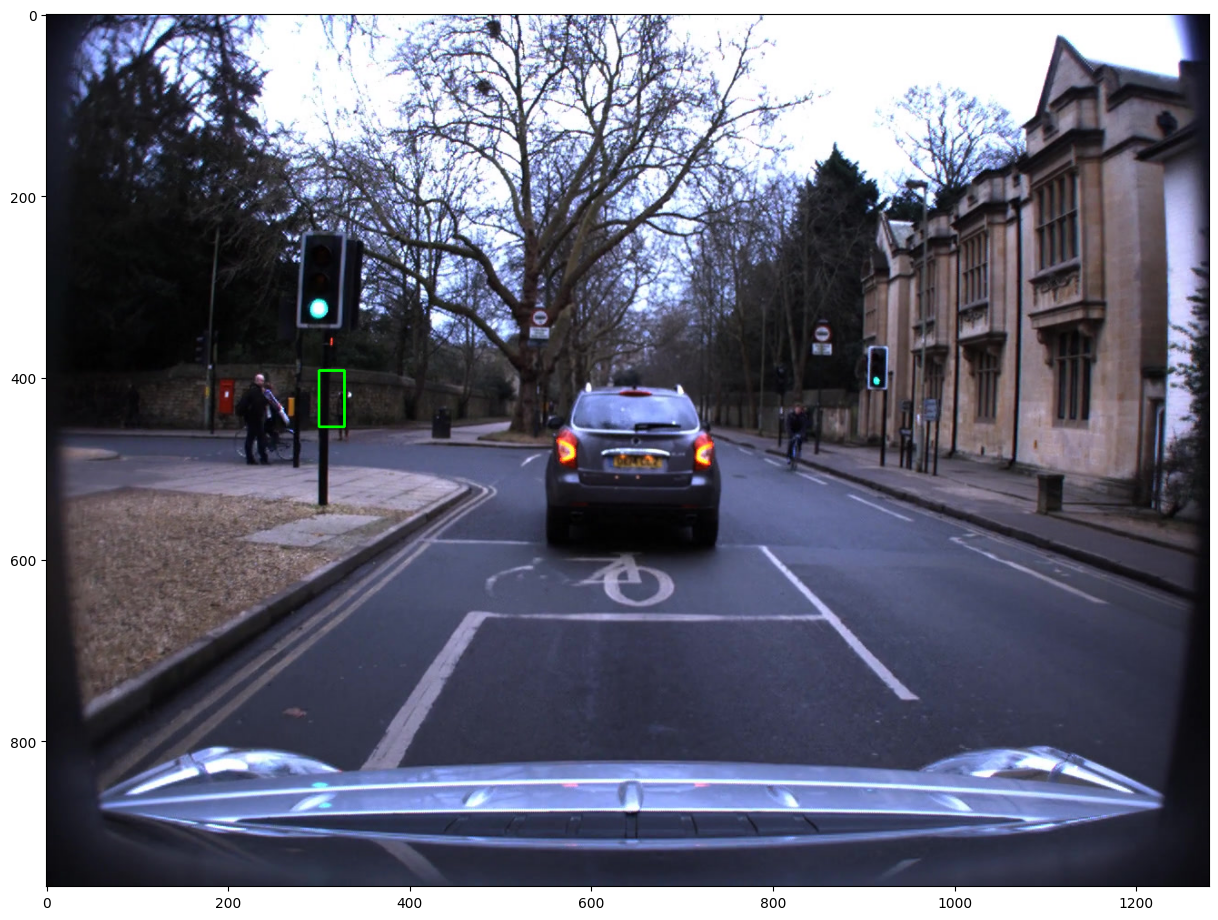

In [8]:

# show img with matplotlib
def show_img(img):
    plt.imshow(img)
    plt.show()

xmin, ymin, xmax, ymax = 160.27 , 218.624, 175.274, 252.928
img = cv2.imread('/road/rgb-images/2015-02-13-09-16-26_stereo_centre_02/00232.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= plot_box_label(img,(int(xmin/682*1280), int(ymin/512*920), int(xmax/682*1280), int(ymax/512*920)), '')
plt.rcParams['figure.figsize'] = (15, 15)

show_img(img)

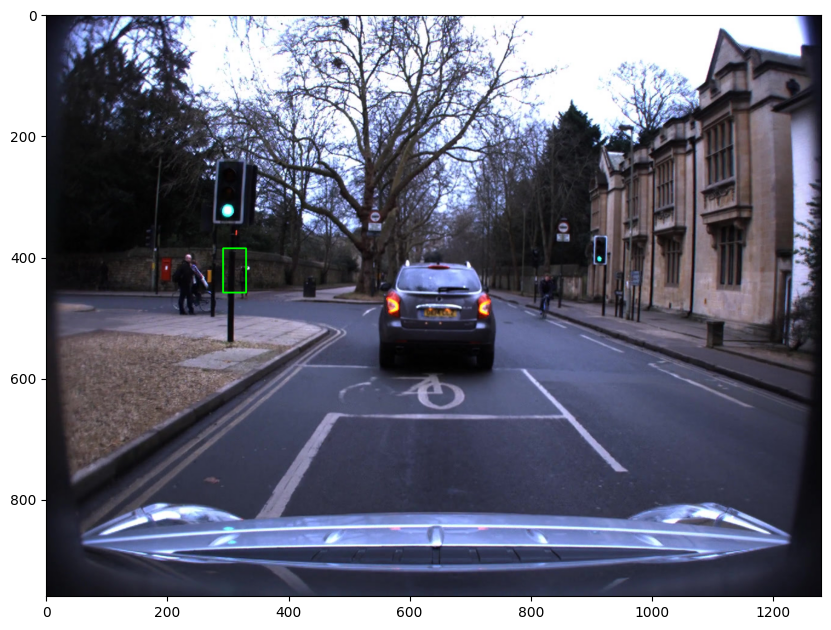

In [9]:
# show img with matplotlib
def show_img(img):
    plt.imshow(img)
    plt.show()

xmin, ymin, xmax, ymax = 156.05943536, 214.93861386, 176.3268945 , 255.49306931
img = cv2.imread('/road/rgb-images/2015-02-13-09-16-26_stereo_centre_02/00232.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= plot_box_label(img,(int(xmin/682*1280), int(ymin/512*920), int(xmax/682*1280), int(ymax/512*920)), '')
plt.rcParams['figure.figsize'] = (10, 10)

show_img(img)